In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 57.5 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 147 kB 84.3 MB/s 
     |████████████████████████████████| 112 kB 61.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f12cc79ce7527448b998c55a8906460e44984420332fb8865b3dbf3a993f4686
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [4]:

from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

In [5]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna

In [6]:
dataset_path_1st = '/content/drive/MyDrive/P3_Data/1st_test/1st_test'
dataset_path_2nd = '/content/drive/MyDrive/P3_Data/2nd_test/2nd_test'
dataset_path_3rd = '/content/drive/MyDrive/P3_Data/3rd_test/4th_test/txt'

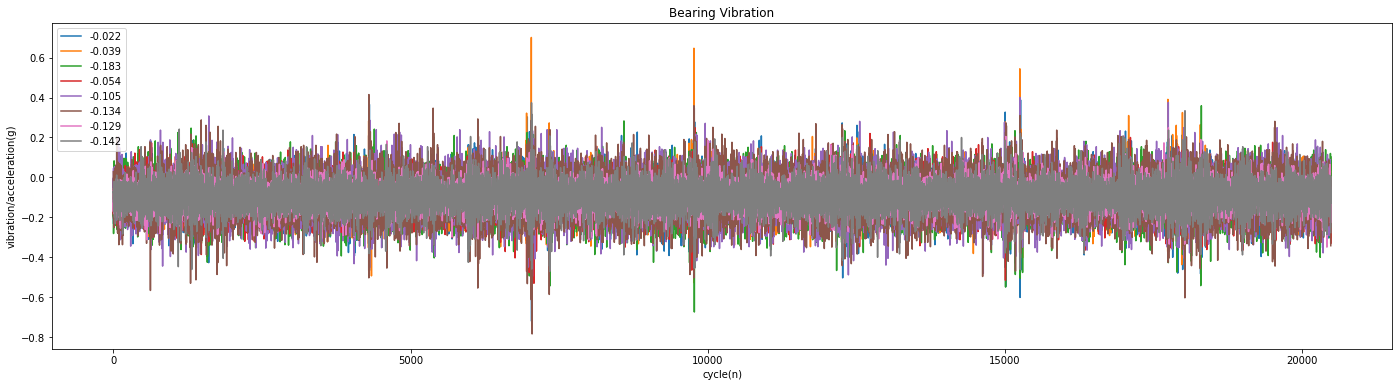

In [7]:
# Test for the first file
dataset = pd.read_csv('/content/drive/MyDrive/P3_Data/1st_test/1st_test/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

In [8]:
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)

        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [9]:
set1 = time_features(dataset_path_1st, id_set=1)
set1.to_csv('set1_timefeatures.csv')

In [10]:
set1 = pd.read_csv("./set1_timefeatures.csv")

In [11]:
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()

,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,B1_x_clearence,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,...,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.127485,0.098575,-0.038621,0.998634,4.981065,0.152221,0.726346,1.177997,4.774991,0.111784,...,0.027031,2.164625,4.842208,0.148647,0.761834,1.314533,4.983898,0.110994,1.183745,5.952366
std,0.006072,0.005345,0.030224,0.197405,0.074409,0.007184,0.079033,0.107634,0.500902,0.005428,...,0.084643,3.346159,0.190066,0.019972,0.395722,0.713627,1.876039,0.010863,0.038067,2.498653
min,0.103651,0.079417,-0.137060,0.279887,4.507776,0.123812,0.510000,0.822000,3.667188,0.090784,...,-1.052182,0.482399,3.715214,0.088486,0.430000,0.681000,2.815276,0.058448,1.055297,2.970951
25%,0.127830,0.096967,-0.058600,0.868275,4.936962,0.152206,0.669000,1.104000,4.407653,0.112297,...,-0.006286,1.045699,4.793158,0.138649,0.547000,0.922000,4.014222,0.107784,1.158352,4.661760
50%,0.128906,0.099051,-0.038491,0.996362,4.983200,0.153733,0.720000,1.175500,4.712466,0.113093,...,0.024396,1.347742,4.869912,0.141205,0.610000,1.062000,4.390117,0.109048,1.165705,5.138212
75%,0.129829,0.101153,-0.017578,1.124417,5.027213,0.155259,0.776000,1.250000,5.063995,0.113818,...,0.060058,1.889175,4.912165,0.159873,0.833500,1.430250,5.088637,0.115484,1.215412,6.147247
max,0.142147,0.129748,0.071573,1.700413,5.304080,0.174977,1.042000,1.533000,7.123639,0.122149,...,1.076577,56.379136,5.335049,0.234521,3.801000,7.122000,19.173531,0.213670,1.386364,25.364433


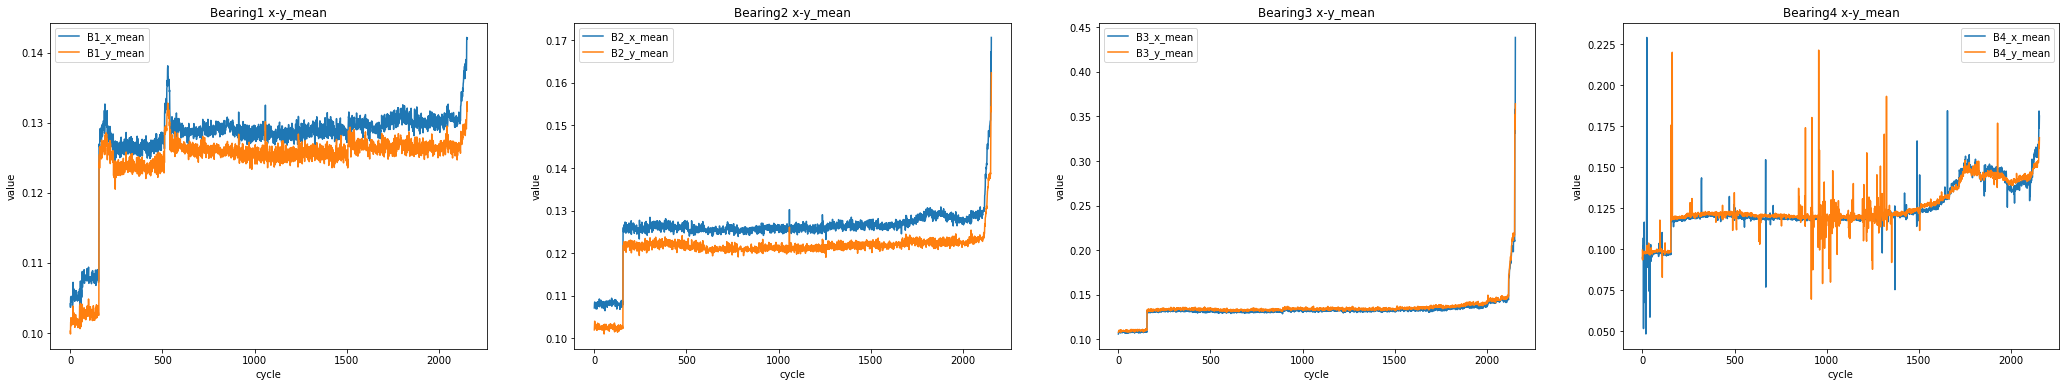

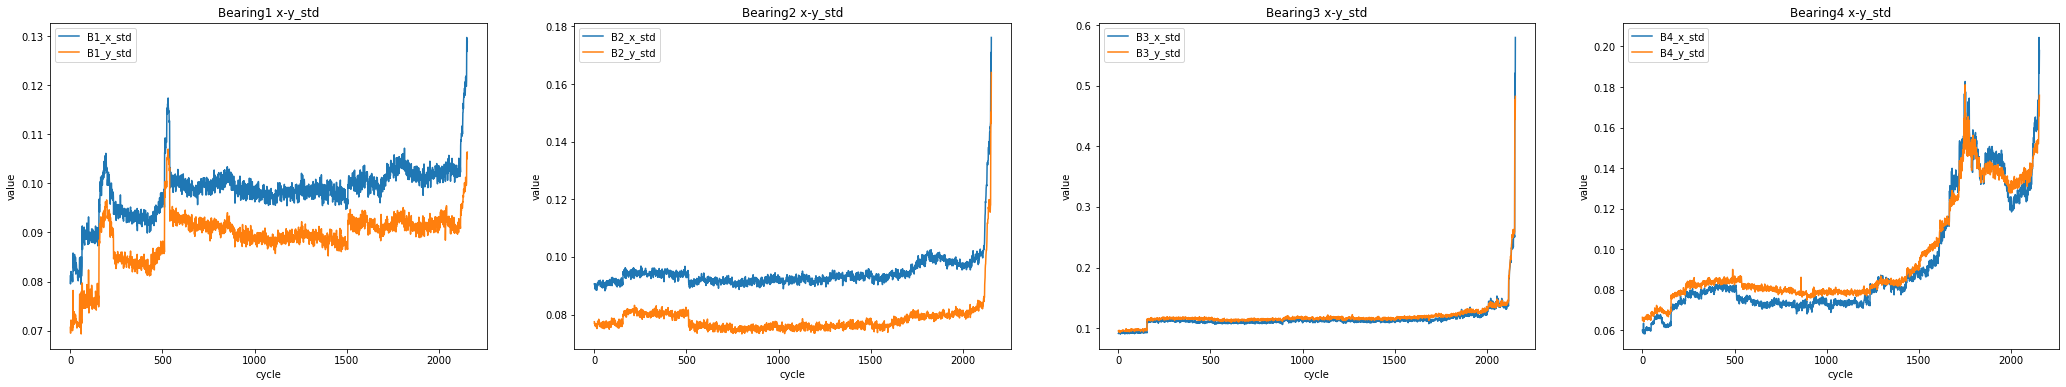

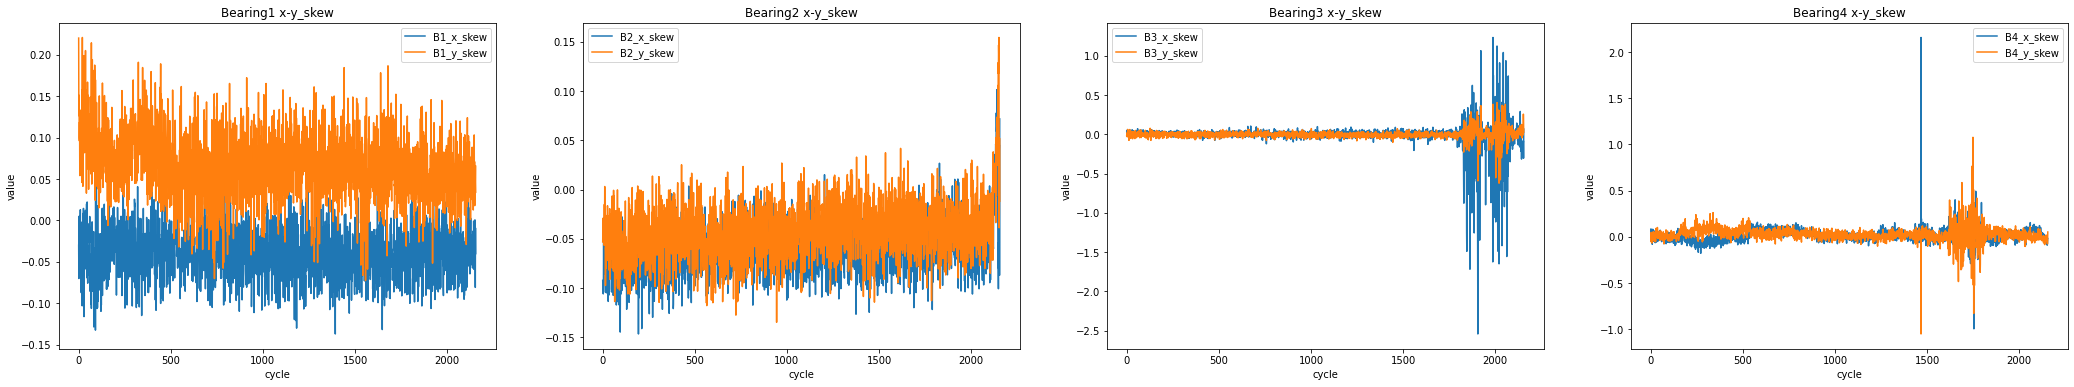

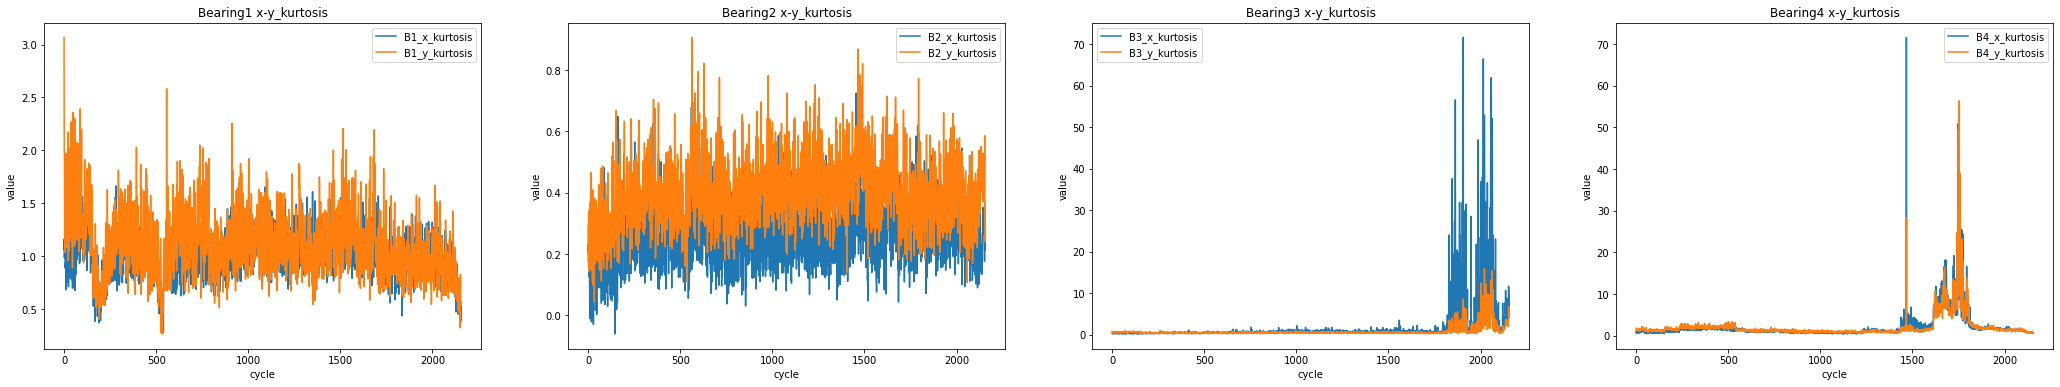

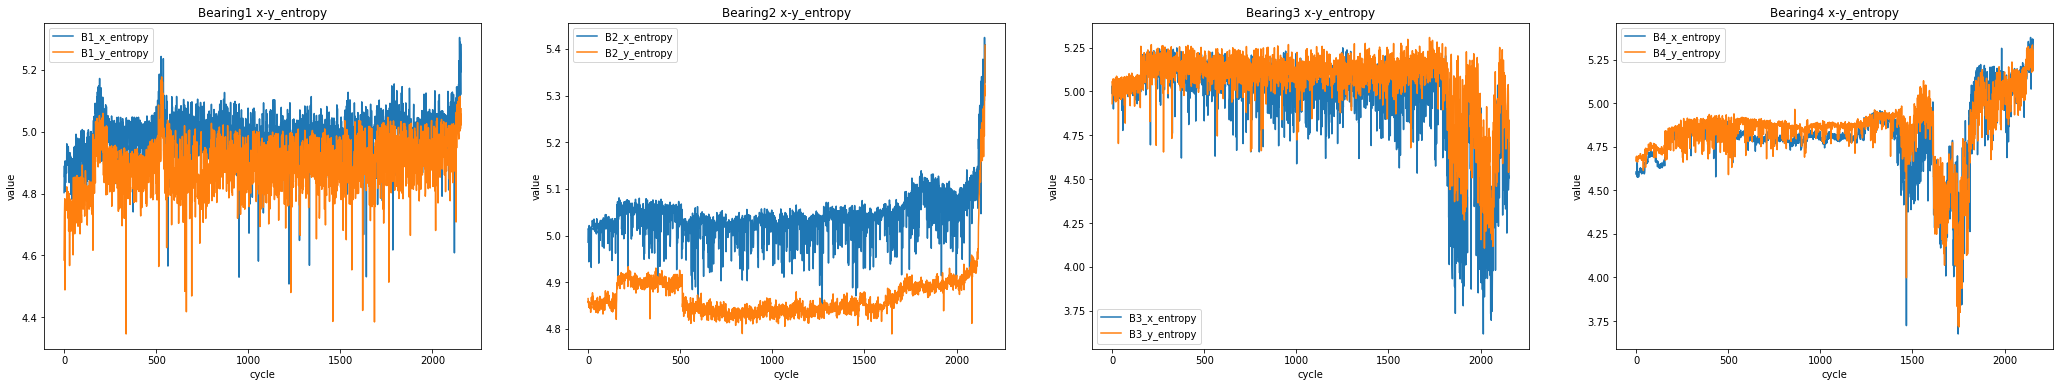

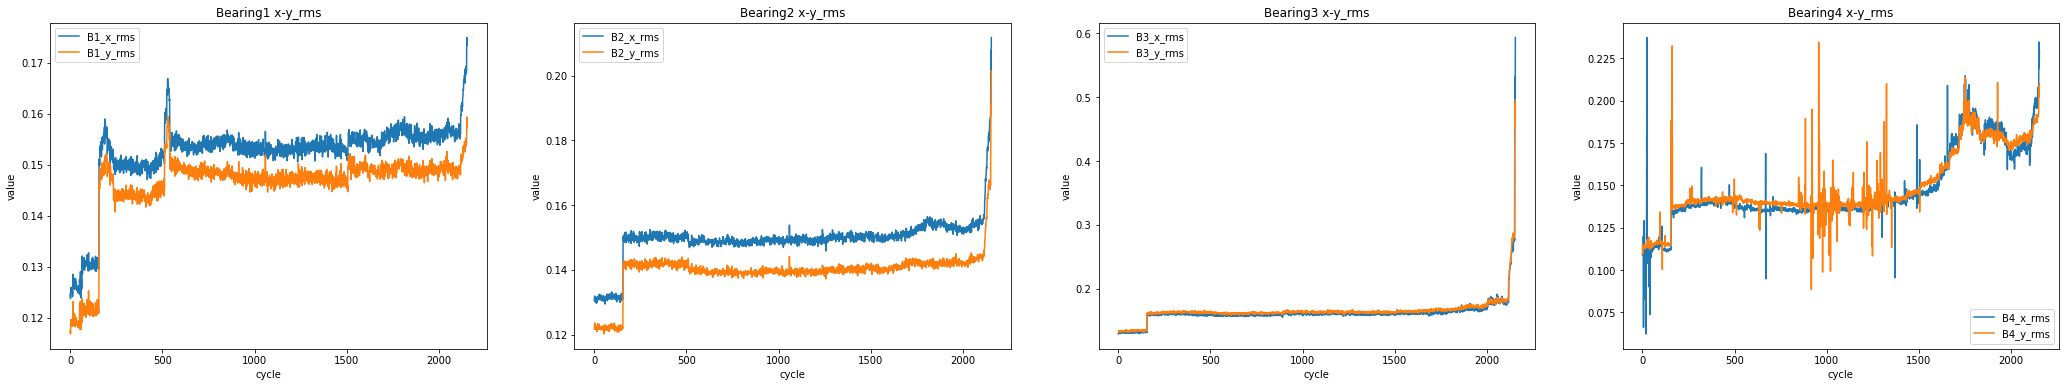

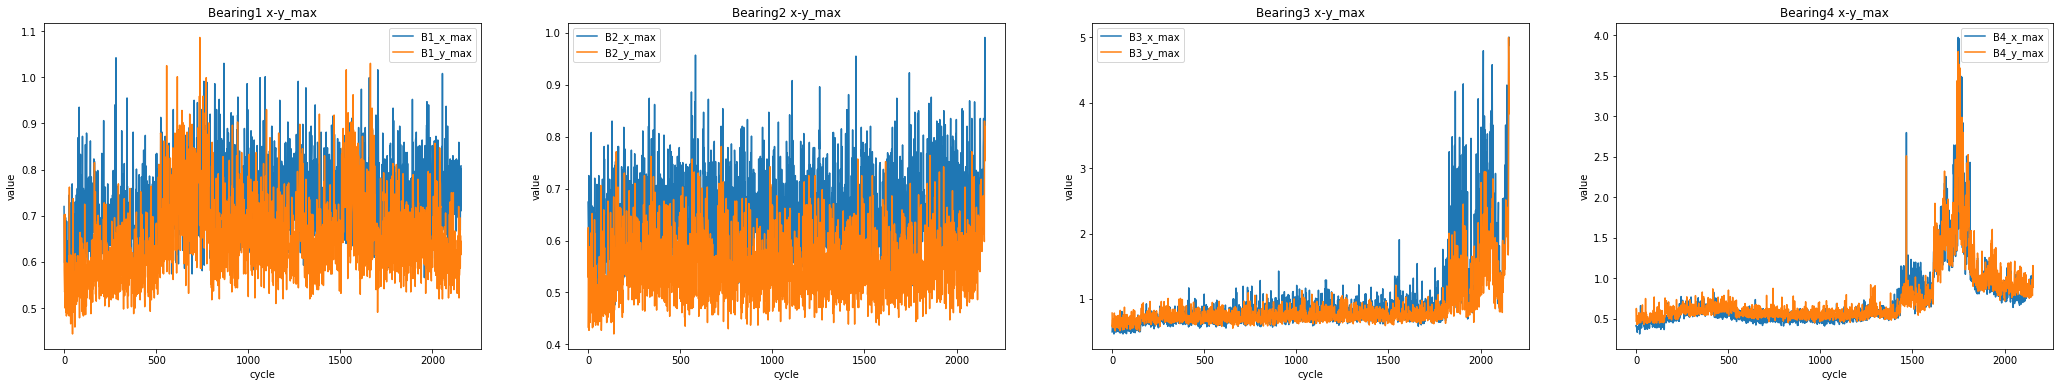

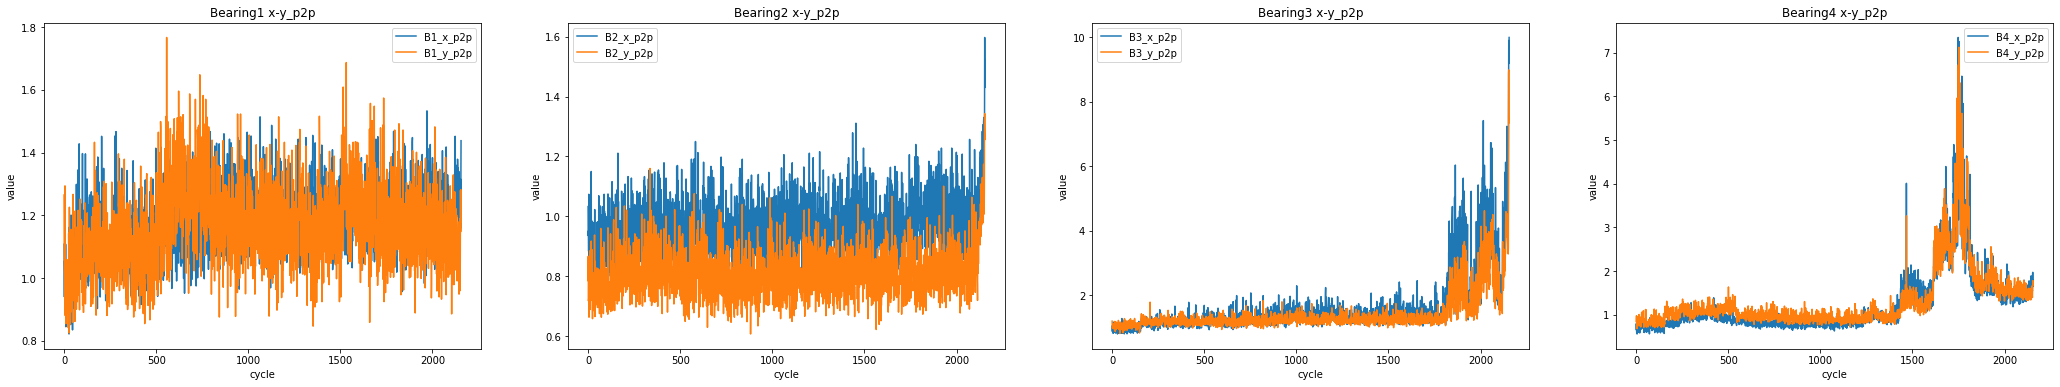

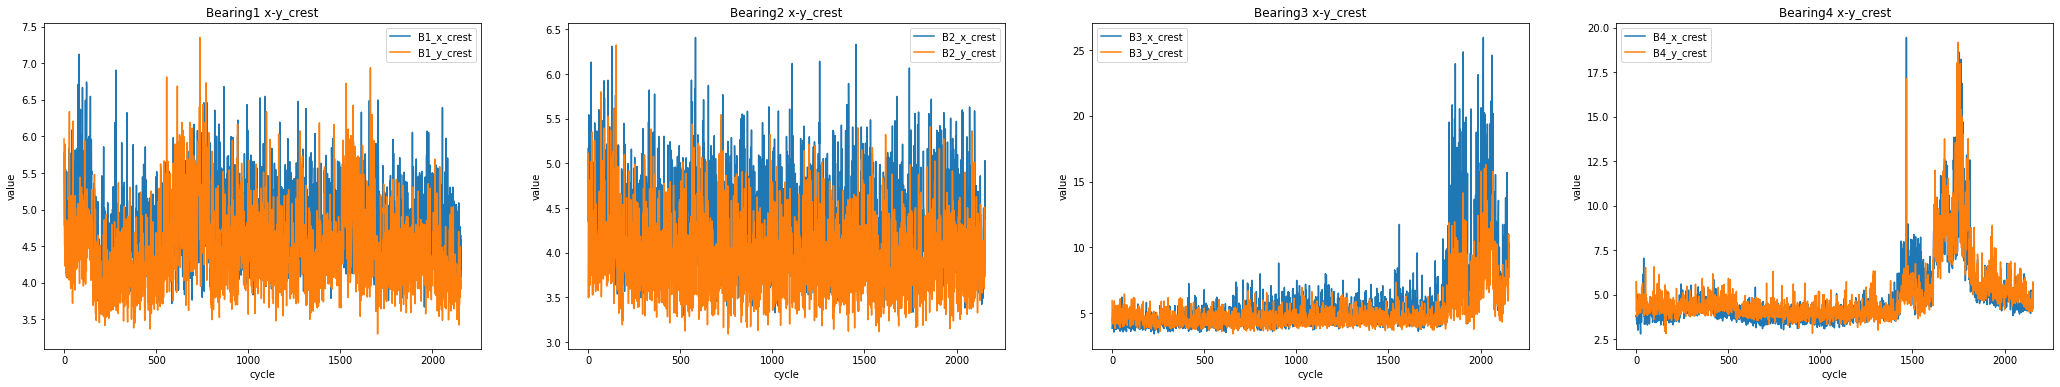

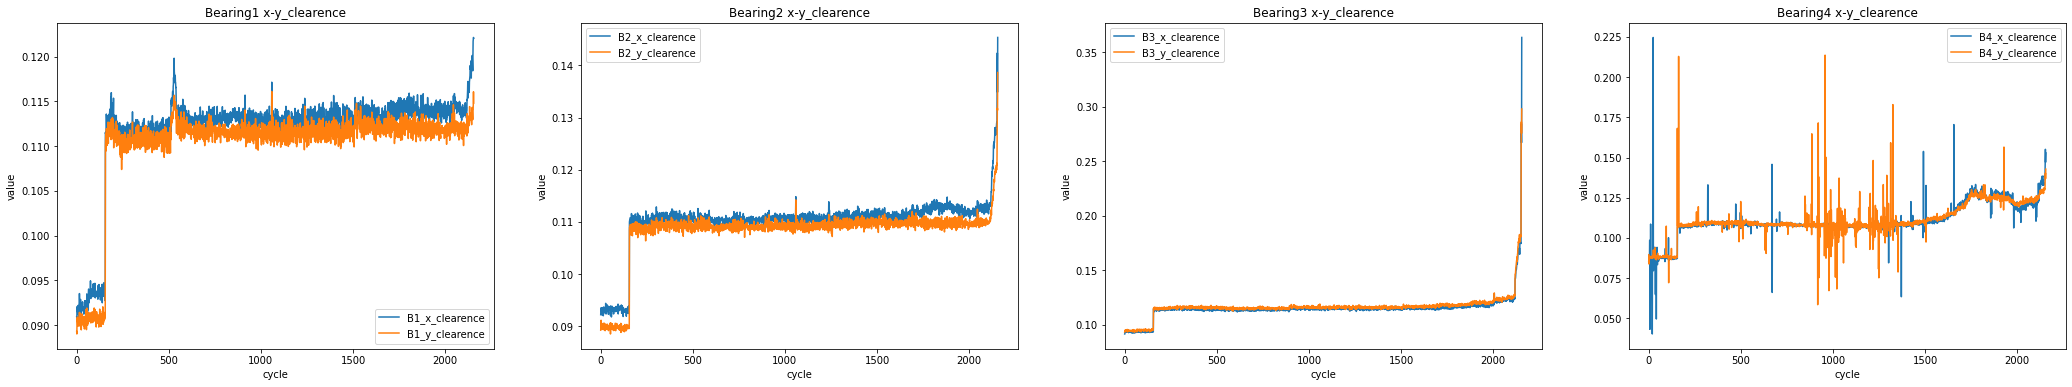

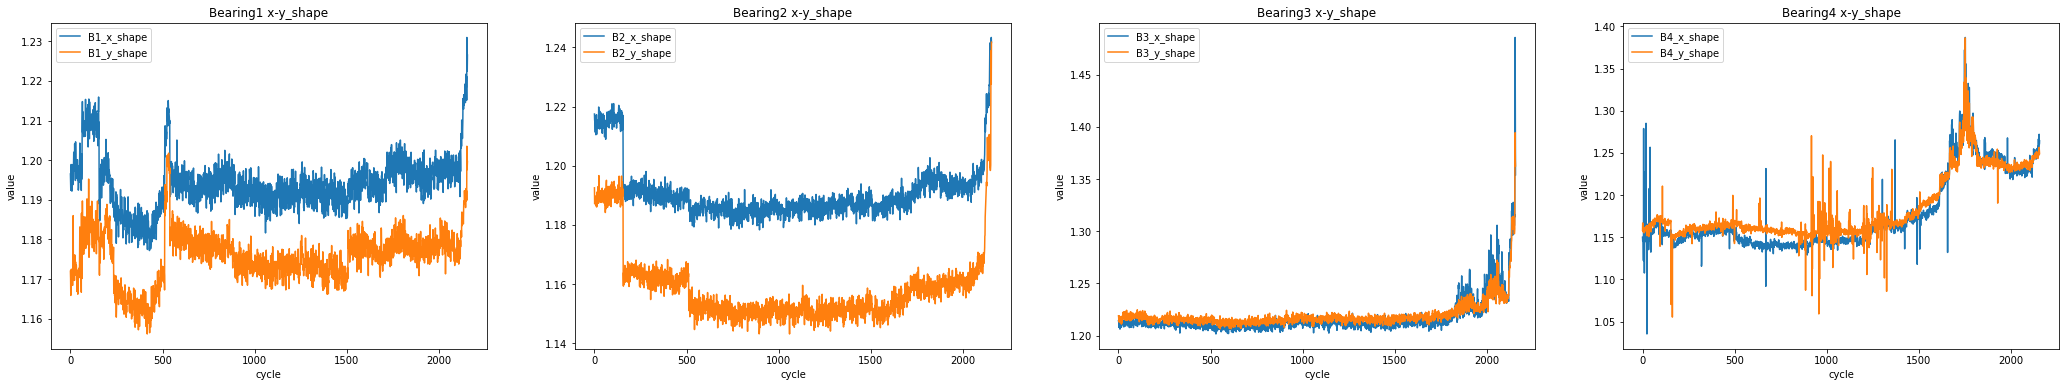

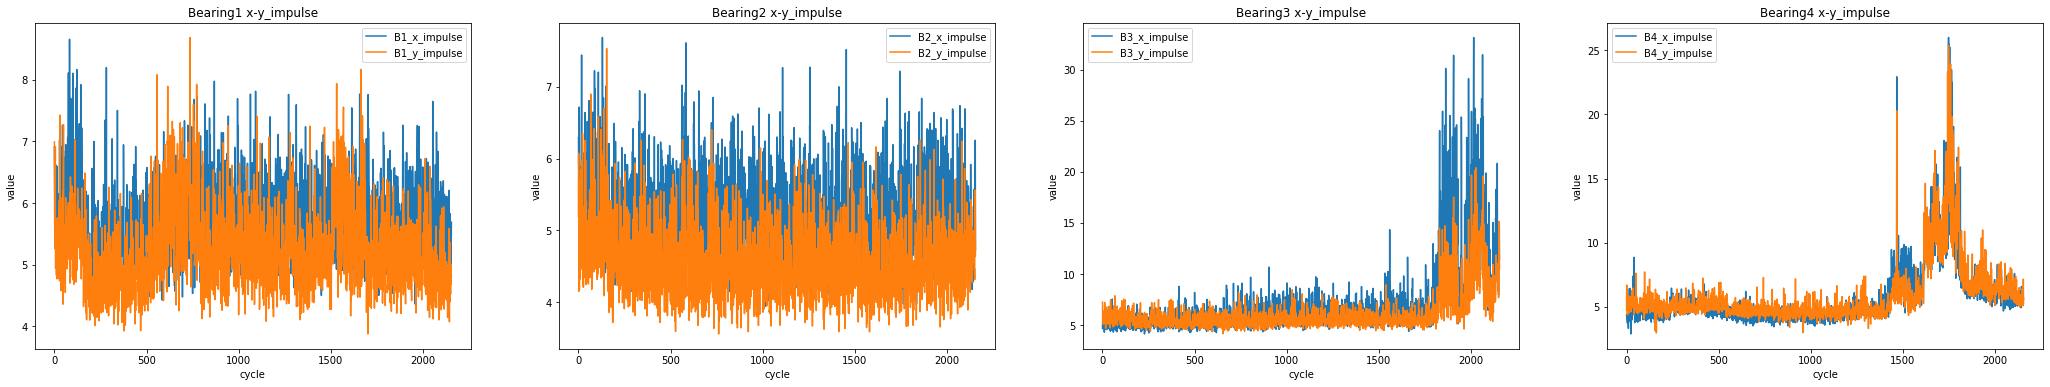

In [12]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    for i in range(4):
        col = bearings_xy[0][i]+tf
        set1[col].plot(figsize = (36,6), title="Bearing{} x-y_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_xy[1][i]+tf
        set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")

In [13]:
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [14]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("1") #early
    if 151 < cnt <=600:
        B1_state.append("3") #suspect
    if 600 < cnt <=1499:
        B1_state.append("2") #normal
    if 1499 < cnt <=2098:
        B1_state.append("3")
    if 2098 < cnt <= 2156:
        B1_state.append("4")#imminent_failure
    #B2
    if cnt<=500:
        B2_state.append("1")
    if 500 < cnt <=2000:
        B2_state.append("2")
    if 2000 < cnt <=2120:
        B2_state.append("3")
    if 2120< cnt <=2156:
        B2_state.append("4")

    #B3
    if cnt<=500:
        B3_state.append("1")
    if 500 < cnt <= 1790:
        B3_state.append("2")
    if 1790 < cnt <=2120:
        B3_state.append("3")
    if 2120 < cnt <=2156:
        B3_state.append("4")
    #B4
    if cnt<=200:
        B4_state.append("1")
    if 200 < cnt <=1000:
        B4_state.append("2")
    if 1000 < cnt <= 1435:
        B4_state.append("3")
    if 1435 < cnt <=1840:
        B4_state.append("4")
    if 1840 < cnt <=2156:
        B4_state.append("5") #Stage_two_failure
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Counter({'3': 1048, '2': 899, '1': 151, '4': 58})
Counter({'2': 1500, '1': 500, '3': 120, '4': 36})
Counter({'2': 1290, '1': 500, '3': 330, '4': 36})
Counter({'2': 800, '3': 435, '4': 405, '5': 316, '1': 200})


,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse,B1_state,B2_state,B3_state,B4_state
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.471,0.845,4.086202,0.089551,1.158299,4.733045,1,1,1,1
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.627,0.900,5.741234,0.083762,1.166936,6.699653,1,1,1,1
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.601,0.977,5.286066,0.088436,1.156631,6.114027,1,1,1,1
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.525,0.852,4.588565,0.088515,1.160373,5.324447,1,1,1,1
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.522,0.871,4.568532,0.088455,1.160343,5.301063,1,1,1,1


In [15]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_skew,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,...,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,0.127560,0.100044,-0.024981,1.334116,4.946657,0.152591,0.768281,1.245925,4.944205,0.111824,...,0.012316,1.125540,4.915563,0.149746,0.701041,1.175864,4.606731,0.111392,1.184353,5.481094
std,0.011487,0.021102,0.106187,3.340440,0.195089,0.017037,0.380306,0.658757,1.868630,0.008977,...,0.068697,1.907041,0.164481,0.017631,0.290447,0.532997,1.337560,0.009314,0.030823,1.752930
min,0.048434,0.058210,-2.542674,-0.060380,3.617485,0.062243,0.312000,0.559000,2.790208,0.040238,...,-1.052182,0.045386,3.715214,0.088486,0.420000,0.608000,2.815276,0.058448,1.055297,2.970951
25%,0.124932,0.091431,-0.058129,0.375305,4.879786,0.148059,0.608000,0.940000,4.115825,0.109906,...,-0.029428,0.457801,4.841772,0.140119,0.557000,0.881000,3.942587,0.109000,1.159891,4.615805
50%,0.128211,0.097648,-0.027155,0.806083,5.005758,0.152825,0.693000,1.106000,4.535037,0.112462,...,0.005879,0.767156,4.892254,0.146617,0.627000,1.096000,4.292514,0.110999,1.175230,5.076103
75%,0.131489,0.110512,0.009014,1.124327,5.053243,0.158982,0.789000,1.286250,5.061653,0.114305,...,0.051146,1.219306,5.011436,0.161695,0.732000,1.252000,4.784112,0.115241,1.214024,5.701873
max,0.438427,0.579446,2.157247,71.578220,5.424562,0.593624,5.000000,9.998000,25.948185,0.363341,...,1.076577,56.379136,5.408023,0.496012,5.000000,8.992000,19.173531,0.297790,1.394270,25.364433


In [16]:
final_data.head()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse,class
0,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,0.090932,...,3.067002,4.585195,0.117496,0.701,1.265,5.966175,0.089295,1.171995,6.992327,1
1,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,0.090784,...,2.001592,4.674025,0.116834,0.581,1.072,4.972861,0.089011,1.170050,5.818495,1
2,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,0.092058,...,1.969713,4.725061,0.118387,0.549,1.018,4.637340,0.090673,1.165883,5.406595,1
3,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,0.091833,...,1.746190,4.750850,0.119007,0.535,1.009,4.495525,0.090402,1.171639,5.267131,1
4,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,0.091479,...,1.182353,4.783104,0.119679,0.537,0.923,4.486993,0.090913,1.171246,5.255374,1


In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
array = final_data.values
X = array[:,:-1]
Y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X, Y)
# show importance scores
print(model.feature_importances_)

[0.02555192 0.3497563  0.00628021 0.06571008 0.05123852 0.15879907
 0.00238274 0.00418112 0.00353329 0.02110677 0.03885292 0.00222213
 0.0055756  0.05740105 0.00701274 0.12546687 0.01065304 0.01940515
 0.0024704  0.00404986 0.00231222 0.00369644 0.03007325 0.0022683 ]


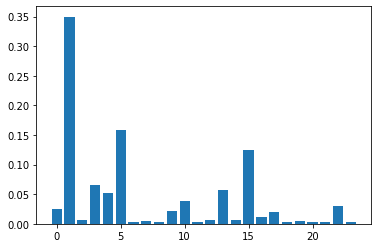

In [19]:
names = final_data.columns.values[:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.show()

In [20]:
m = final_data['class']
one_hot = pd.get_dummies(m)
one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8624 entries, 0 to 8623
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       8624 non-null   uint8
 1   2       8624 non-null   uint8
 2   3       8624 non-null   uint8
 3   4       8624 non-null   uint8
 4   5       8624 non-null   uint8
dtypes: uint8(5)
memory usage: 42.2 KB


In [21]:
X = final_data.drop(['class'],axis=1)

In [22]:
X.head()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_skew,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse
0,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,0.090932,...,0.220227,3.067002,4.585195,0.117496,0.701,1.265,5.966175,0.089295,1.171995,6.992327
1,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,0.090784,...,0.126542,2.001592,4.674025,0.116834,0.581,1.072,4.972861,0.089011,1.170050,5.818495
2,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,0.092058,...,0.151147,1.969713,4.725061,0.118387,0.549,1.018,4.637340,0.090673,1.165883,5.406595
3,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,0.091833,...,0.099599,1.746190,4.750850,0.119007,0.535,1.009,4.495525,0.090402,1.171639,5.267131
4,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,0.091479,...,0.096043,1.182353,4.783104,0.119679,0.537,0.923,4.486993,0.090913,1.171246,5.255374


In [23]:
X = final_data[["Bx_std", "Bx_kurtosis", "Bx_rms", "By_std", "By_clearence"]]
y = one_hot
X = X.values
X = X.reshape(X.shape[0],X.shape[1],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)

In [24]:
X.shape

(8624, 5, 1)

In [25]:
X_train.shape

(6036, 5, 1)

In [26]:
!pip install shap
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import ssl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.7 MB/s 


In [27]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

print(type(xgb_cl))


<class 'xgboost.sklearn.XGBClassifier'>


In [28]:
X = final_data.drop(['class'],axis=1)
y = final_data.pop("class")
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)

In [29]:
from sklearn.metrics import accuracy_score

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

0.8860123647604328

In [30]:
 cb_clf = cb.CatBoostClassifier(verbose = False)
 cb_clf.fit(X_train, y_train)
 preds = cb_clf.predict(X_test)
accuracy_score(y_test, preds)

0.8918083462132921

In [31]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    lgbm.LGBMClassifier()
    ]

for name, clf in zip(names,classifiers):
    print("training "+name+" ...")
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print('Score of'+name+' is: '+str(score))

training Nearest Neighbors ...
Score ofNearest Neighbors is: 0.7156105100463679
training Linear SVM ...
Score ofLinear SVM is: 0.597758887171561
training RBF SVM ...
Score ofRBF SVM is: 0.7272024729520865
training Decision Tree ...
Score ofDecision Tree is: 0.7368624420401855
training Random Forest ...
Score ofRandom Forest is: 0.6893353941267388
training Neural Net ...
Score ofNeural Net is: 0.6904945904173106
training AdaBoost ...
Score ofAdaBoost is: 0.6534003091190108
training Naive Bayes ...
Score ofNaive Bayes is: 0.6201700154559505
training QDA ...
Score ofQDA is: 0.6843122102009274
training XGBoost ...
Score ofXGBoost is: 0.8860123647604328
training CatGBoost ...
Score ofCatGBoost is: 0.8918083462132921
training LightGBoost ...
Score ofLightGBoost is: 0.8910355486862442


In [32]:
from sklearn import metrics

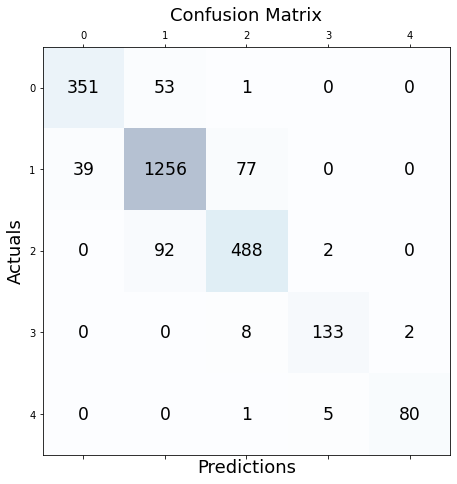

In [33]:
conf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=preds)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.9 MB/s 
     |████████████████████████████████| 133 kB 52.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=846e375a61ac48caeb496cba65c9c74f2ab83137c5f364d301cd08d9d6891b41
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompa

In [36]:
import eli5

In [37]:
X_test.shape

(2588, 24)

In [38]:
eli5.show_weights(xgb_cl.get_booster())

Weight,Feature
0.1956,Bx_rms
0.0803,Bx_kurtosis
0.0739,Bx_clearence
0.0648,By_std
0.0577,Bx_std
0.0556,By_shape
0.0547,Bx_shape
0.0525,By_kurtosis
0.0455,By_entropy
0.0439,Bx_impulse


In [39]:
X_test.head()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_skew,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse
8159,0.139720,0.129783,-0.131041,9.736330,4.366252,0.175225,1.484,2.959,8.469107,0.121117,...,-0.158286,7.178825,4.481466,0.169099,1.501,2.592,8.876441,0.119399,1.232844,10.943270
103,0.107651,0.088454,0.017664,0.960840,4.986703,0.129764,0.542,0.947,4.176819,0.093638,...,0.068724,1.048470,4.821075,0.121089,0.525,1.001,4.335661,0.090894,1.178544,5.109769
642,0.126914,0.098664,-0.097861,0.947805,4.888448,0.151966,0.835,1.245,5.494646,0.111150,...,0.001595,0.736428,4.984677,0.147140,0.657,1.062,4.465140,0.110301,1.179688,5.267472
1956,0.129679,0.099211,0.013898,0.771320,5.102654,0.154342,0.566,0.983,3.667188,0.114003,...,0.047551,0.918770,4.930298,0.149092,0.627,1.118,4.205460,0.112633,1.174261,4.938307
6992,0.119871,0.076857,0.042721,1.684359,4.658229,0.137787,0.676,1.277,4.906136,0.108506,...,0.095878,3.061165,4.675374,0.143346,0.764,1.460,5.329765,0.110380,1.166265,6.215918


In [ ]:
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]

In [ ]:
explainer = shap.DeepExplainer(model, background)

In [ ]:
shap_values = explainer.shap_values(X)

In [ ]:
shap_explainer = shap.TreeExplainer(xgb_cl)
test_shap_values = shap_explainer.shap_values(X_test)
print('Expected Value:', shap_explainer.expected_value)

Expected Value: [0.1889635, 1.6798385, 0.8428775, -0.76272774, -2.05393]


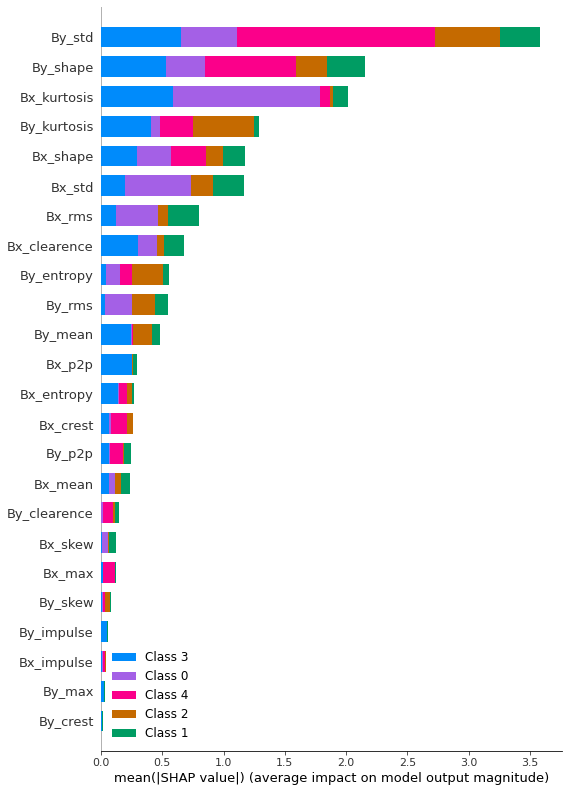

In [ ]:
shap.summary_plot(test_shap_values, X_test, plot_type="bar", max_display=30)